In [1]:
import sys
sys.path.append('..')

import torch
from common import image
from torchvision import transforms
from ssl_ import ssl_model, ssl_dataset
from torch.utils.data import DataLoader
from model import enc, tsfm
import random

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
device = torch.device('mps')

In [3]:
model = ssl_model.SSL(d_cont=384, d_coord_emb=64, d_head=64, n_enc_layer=20)
model.to(device)
pass

In [5]:
od_base_state = torch.load('/Users/zx/Documents/ml/restart/resources/od_base_1260.pt', map_location=device)
ssl_state = torch.load('/Users/zx/Documents/ml/restart/resources/ssl_411.pt', map_location=device)

In [6]:
state = model.state_dict()
for k in ssl_state:
    if k in od_base_state:
        state[k] = od_base_state[k]
    else:
        state[k] = ssl_state[k]
model.load_state_dict(state)

<All keys matched successfully>

/Users/zx/Documents/ml/restart/notebook/../ssl_/ssl_dataset.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img)
/Users/zx/miniforge3/envs/pytorch/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialia

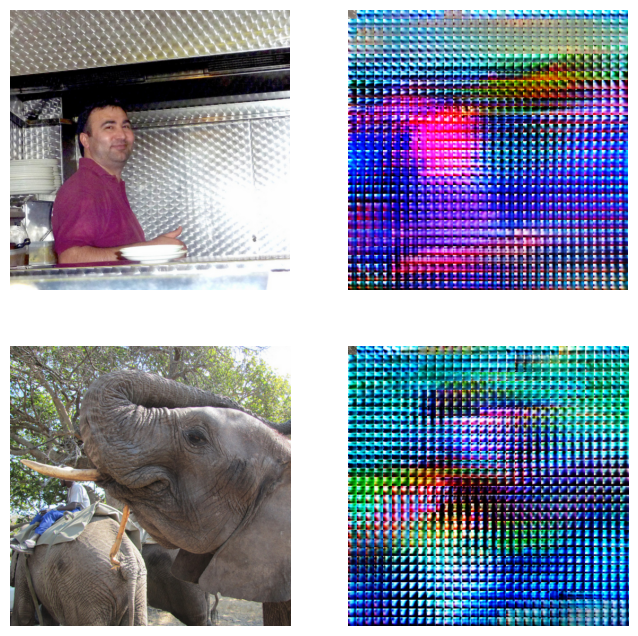

In [7]:
ds = ssl_dataset.SslDataset(train=False, sample_num=4)
dl = DataLoader(ds, batch_size=2, shuffle=False)

for j, img in enumerate(dl):
    img_ = img.to(device)
    img_ = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(img_)
    with torch.no_grad():
        pred = model(img_)
    break

img = torch.permute(img, [0, 2, 3, 1])
img_p = image.patchify(img, patch_size=16, channel_first=False)
patch0 = img_p[:, 0, 0].view(-1, 1, 16, 16, 3)
img_restored = torch.concat([patch0, pred.cpu()], dim=1)
img_restored = img_restored.reshape(2, 32, 32, 16, 16, 3).permute(0, 1, 3, 2, 4, 5).contiguous().view(2, 512, 512, 3)

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
for i in range(2):
    axes[i, 0].imshow(img[i])
    axes[i, 1].imshow(img_restored[i].detach().numpy())
    axes[i, 0].axis('off')
    axes[i, 1].axis('off')

In [8]:
encoder = enc.Encoder(n_enc_layer=20, d_cont=384, d_head=64, d_coord_emb=64)
encoder.to(device)
state = encoder.state_dict()
ssl_state = model.encoder.state_dict()
for k in state.keys():
    if k in ssl_state:
        state[k] = ssl_state[k]
encoder.load_state_dict(state)

<All keys matched successfully>

In [9]:
ln = torch.nn.LayerNorm(384)
ln.to(device)

LayerNorm((384,), eps=1e-05, elementwise_affine=True)

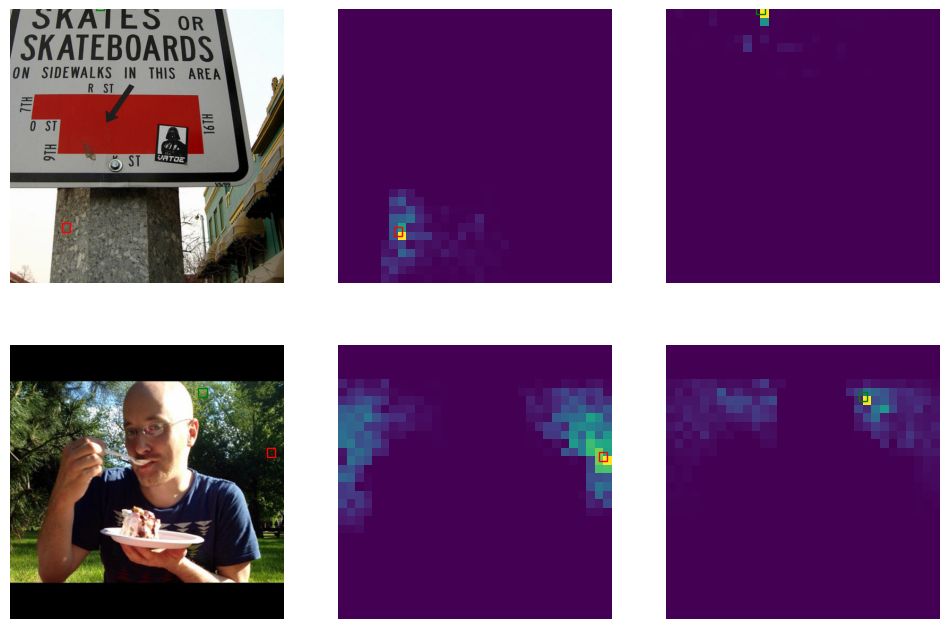

In [24]:
ds = ssl_dataset.SslDataset(train=False, sample_num=4)
dl = DataLoader(ds, batch_size=2, shuffle=False)

for j, img in enumerate(dl):
    img_ = img.to(device)
    img_ = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(img_)
    with torch.no_grad():
        enc_out, _ = encoder(img_)
        enc_out = ln(enc_out)
    break

img = torch.permute(img, [0, 2, 3, 1])
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
for i in range(2):
    axes[i, 0].imshow(img[i])
    axes[i, 0].axis('off')
    for j in range(2):
        color = 'red' if j == 0 else 'green'
        ref_point = random.randint(0, 1023)
        y2, x2 = ref_point // 32, ref_point % 32
        x1, y1 = x2 - 1, y2 - 1
        axes[i, 0].add_patch(
                plt.Rectangle((x1 * 16, y1 * 16), (x2 - x1) * 16, (y2 - y1) * 16, fill=False, edgecolor=color, lw=1))
        axes[i, j + 1].add_patch(
                plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor=color, lw=1))
        ref = enc_out[i, ref_point].view(1, 1, -1)
        attn = tsfm.attention(ref, enc_out[i:i+1]).cpu().view(32, 32)
        axes[i, j + 1].imshow(attn)
        axes[i, j + 1].axis('off')

In [46]:
attn.flatten().argmax()

tensor(511, device='mps:0')

In [83]:
enc_out.shape

torch.Size([2, 1024, 384])

In [49]:
ref_point % 32

31

In [50]:
511 // 32

15

In [51]:
511 % 32

31

In [56]:
attn.shape

torch.Size([32, 32])

In [58]:
attn.argmax(keepdim=True)

tensor([[652]])

In [59]:
a = torch.randn(4, 4)

In [60]:
a

tensor([[-0.6114,  0.5636, -1.9389, -0.9919],
        [ 0.0484, -1.7381,  0.2516, -1.5117],
        [-0.1245,  2.0465,  0.6280, -0.3065],
        [-1.1824,  0.1234,  0.4723, -1.3334]])

In [61]:
a.argmax()

tensor(9)

In [62]:
9 // 4, 9 % 4

(2, 1)